In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import csv

# Introduction
Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

# Define the target questions

# Data Loading

In [2]:
df_list = []
with open("HomeCredit_columns_description.csv", 'r',errors='ignore') as file:
    reader = csv.reader(file)
    for row in reader:
        df_list.append(pd.DataFrame({'table_name':row[1],'col_name':row[2],\
                                     'description':row[3]},index=list('A')))
df_description = pd.concat(df_list,axis=0).reset_index()
df_description.drop(columns='index',inplace=True)

In [3]:
def view_description_columns(table,data=df_description,column=None):
    """
    view_description_columns(table,data=df_description,column=None) designed for columns descriptions check
    :param table:
    :param data:
    :param column:
    :return: The descriptions of each column for corresponding table
    """
    if column is not None:
        return data[(data['table_name']==table)&(df_description['col_name']==column)][['col_name','description']]
    else:
        return data[data['table_name']==table][['col_name','description']]
    

## Previsous Application Columns Description

In [4]:
# Read Previous Application table
previous_application = pd.read_csv('previous_application.csv')

In [5]:
previous_application_description = view_description_columns(table='previous_application.csv',data=df_description)

In [6]:
previous_application_description.head(10)

,col_name,description
174,SK_ID_PREV,ID of previous credit in Home credit related t...
175,SK_ID_CURR,ID of loan in our sample
176,NAME_CONTRACT_TYPE,"Contract product type (Cash loan, consumer loa..."
177,AMT_ANNUITY,Annuity of previous application
178,AMT_APPLICATION,For how much credit did client ask on the prev...
179,AMT_CREDIT,Final credit amount on the previous applicatio...
180,AMT_DOWN_PAYMENT,Down payment on the previous application
181,AMT_GOODS_PRICE,Goods price of good that client asked for (if ...
182,WEEKDAY_APPR_PROCESS_START,On which day of the week did the client apply ...
183,HOUR_APPR_PROCESS_START,Approximately at what day hour did the client ...


## Installments Columns Description

In [7]:
installments  = pd.read_csv('installments_payments.csv')

In [8]:
installments_description = view_description_columns(table='installments_payments.csv',data=df_description)

In [9]:
installments_description.head(10)

,col_name,description
212,SK_ID_PREV,ID of previous credit in Home credit related t...
213,SK_ID_CURR,ID of loan in our sample
214,NUM_INSTALMENT_VERSION,Version of installment calendar (0 is for cred...
215,NUM_INSTALMENT_NUMBER,On which installment we observe payment
216,DAYS_INSTALMENT,When the installment of previous credit was su...
217,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...
218,AMT_INSTALMENT,What was the prescribed installment amount of ...
219,AMT_PAYMENT,What the client actually paid on previous cred...


## POS_CASH_Balance Column Descriptions

In [10]:
pos_cash_bal = pd.read_csv('POS_CASH_balance.csv')

In [11]:
pos_cash_bal_description = view_description_columns(table='POS_CASH_balance.csv',data=df_description)

In [12]:
pos_cash_bal_description.head(10)

,col_name,description
143,SK_ID_PREV,ID of previous credit in Home Credit related t...
144,SK_ID_CURR,ID of loan in our sample
145,MONTHS_BALANCE,Month of balance relative to application date ...
146,CNT_INSTALMENT,Term of previous credit (can change over time)
147,CNT_INSTALMENT_FUTURE,Installments left to pay on the previous credit
148,NAME_CONTRACT_STATUS,Contract status during the month
149,SK_DPD,DPD (days past due) during the month of previo...
150,SK_DPD_DEF,DPD during the month with tolerance (debts wit...


## Credit Card Balance Columns Description

In [13]:
credit_card_bal = pd.read_csv('credit_card_balance.csv')

In [14]:
credit_card_bal_description = view_description_columns('credit_card_balance.csv',data=df_description)

In [15]:
credit_card_bal_description.head(10)

,col_name,description
151,SK_ID_PREV,ID of previous credit in Home credit related t...
152,SK_ID_CURR,ID of loan in our sample
153,MONTHS_BALANCE,Month of balance relative to application date ...
154,AMT_BALANCE,Balance during the month of previous credit
155,AMT_CREDIT_LIMIT_ACTUAL,Credit card limit during the month of the prev...
156,AMT_DRAWINGS_ATM_CURRENT,Amount drawing at ATM during the month of the ...
157,AMT_DRAWINGS_CURRENT,Amount drawing during the month of the previou...
158,AMT_DRAWINGS_OTHER_CURRENT,Amount of other drawings during the month of t...
159,AMT_DRAWINGS_POS_CURRENT,Amount drawing or buying goods during the mont...
160,AMT_INST_MIN_REGULARITY,Minimal installment for this month of the prev...


## Bureau Columns description
- All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
- For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

In [16]:
bureau = pd.read_csv('bureau.csv')

In [17]:
bureau_description = view_description_columns('bureau.csv',data=df_description)

In [18]:
bureau_description.head(10)

,col_name,description
123,SK_ID_CURR,ID of loan in our sample - one loan in our sam...
124,SK_BUREAU_ID,Recoded ID of previous Credit Bureau credit re...
125,CREDIT_ACTIVE,Status of the Credit Bureau (CB) reported credits
126,CREDIT_CURRENCY,Recoded currency of the Credit Bureau credit
127,DAYS_CREDIT,How many days before current application did c...
128,CREDIT_DAY_OVERDUE,Number of days past due on CB credit at the ti...
129,DAYS_CREDIT_ENDDATE,Remaining duration of CB credit (in days) at t...
130,DAYS_ENDDATE_FACT,Days since CB credit ended at the time of appl...
131,AMT_CREDIT_MAX_OVERDUE,Maximal amount overdue on the Credit Bureau cr...
132,CNT_CREDIT_PROLONG,How many times was the Credit Bureau credit pr...


## Bureau balance Columns Description
- Monthly balances of previous credits in Credit Bureau.
- This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

In [19]:
bureau_bla = pd.read_csv('bureau_balance.csv')

In [20]:
bureau_bla_description = view_description_columns('bureau_balance.csv',data=df_description)

In [21]:
bureau_bla_description.head()

,col_name,description
140,SK_BUREAU_ID,Recoded ID of Credit Bureau credit (unique cod...
141,MONTHS_BALANCE,Month of balance relative to application date ...
142,STATUS,Status of Credit Bureau loan during the month ...


## Application Columns Description

In [22]:
application_train = pd.read_csv('application_train.csv')

In [23]:
application_test = pd.read_csv('application_test.csv')

In [24]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# Exploratory Data Analysis

### Missing Values Check and Imputation

In [36]:
from sklearn.impute import SimpleImputer
import missingno as mn

In [33]:
def missing_val_stat(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [77]:
def missing_value_check(data,threshold=0.5):

    print('Plotting missing values pattern for {}....'.format('data'))
    mn.matrix(data)
    plt.title('Missing Values Check for {} Table'.format('data'))
    plt.show()
    print('calculating for the total number of missing values in {} with threshold {} %....'.format('data',threshold*100))
    missing_value_check = missing_val_stat(data)
    missing_value_check.sort_values(by='Total', ascending=False, inplace=True)
    missing_value_check = missing_value_check[missing_value_check['Percent'] > threshold]
    print('The number of columns with over 50% missing values is: {}'.format(len(missing_value_check))) # print the number of columns with more than 50% missing values
    return missing_value_check

#### Missing Values Check

##### Missing Values Check for Application Table

Plotting missing values pattern for data....


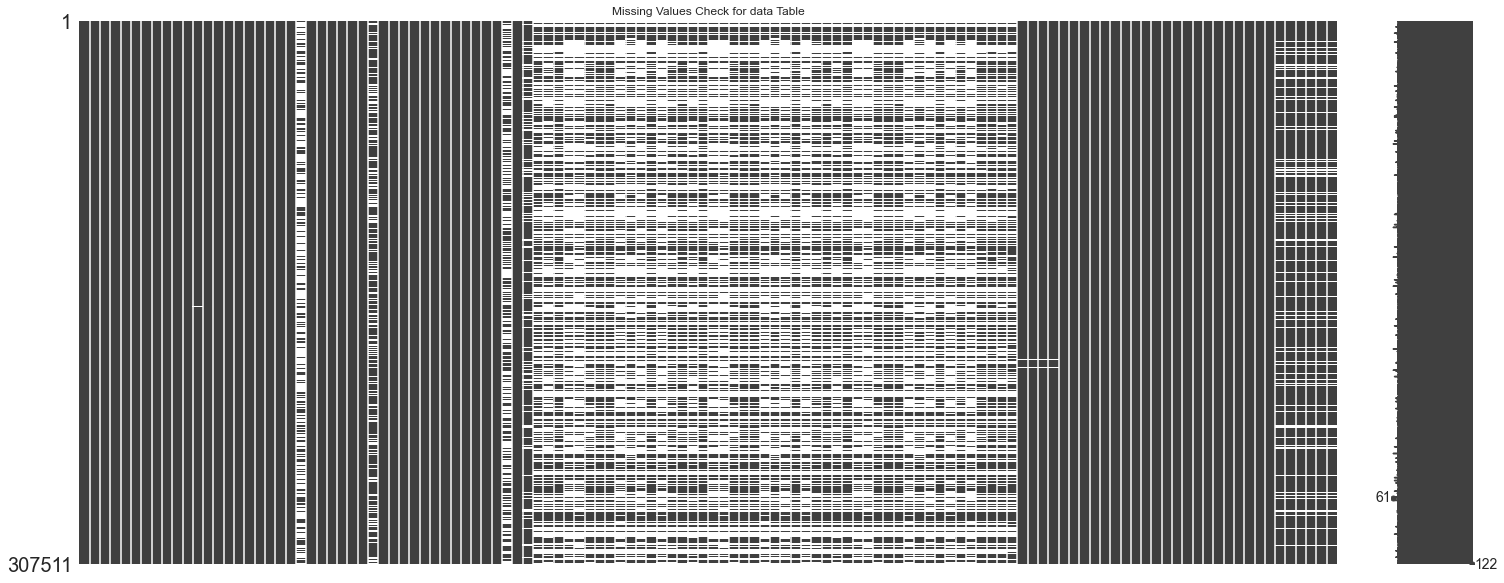

calculating for the total number of missing values in data with threshold 50.0 %....
The number of columns with over 50% missing values is: 57


,Total,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_MODE,214865,69.872297
COMMONAREA_AVG,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953


In [78]:
missing_value_check( application_train)

Plotting missing values pattern for data....


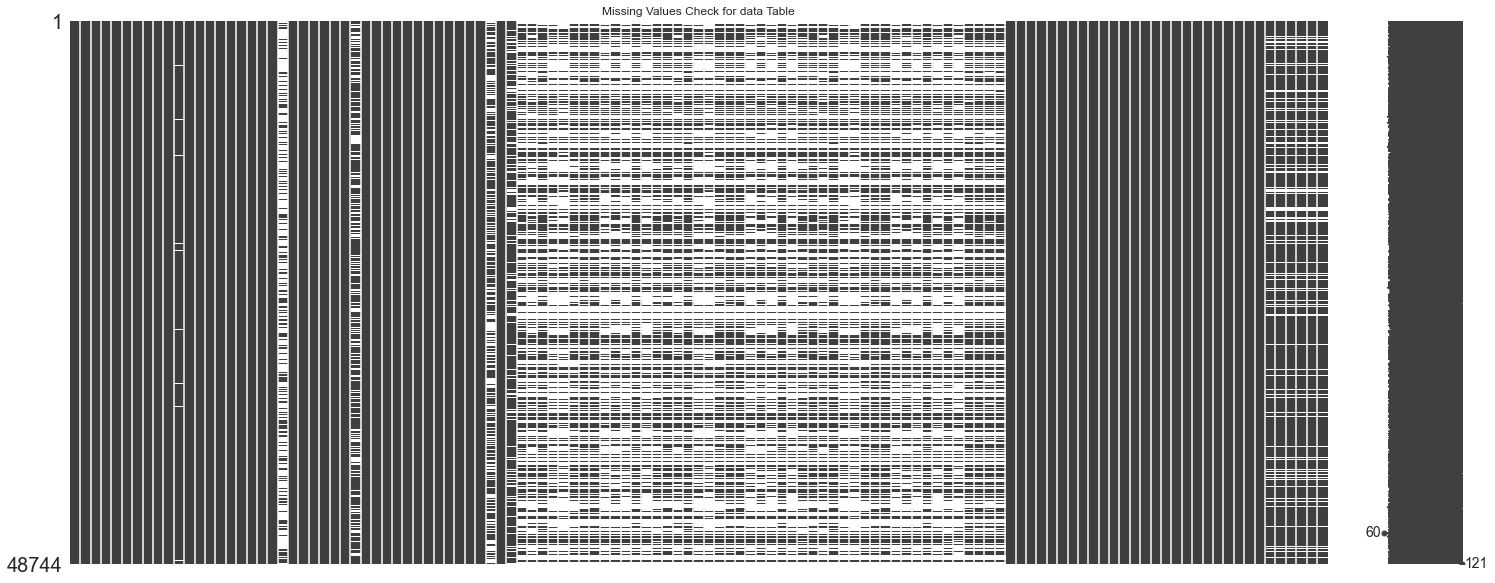

calculating for the total number of missing values in data with threshold 50.0 %....
The number of columns with over 50% missing values is: 58


,Total,Percent
COMMONAREA_AVG,33495,68.716150
COMMONAREA_MEDI,33495,68.716150
COMMONAREA_MODE,33495,68.716150
NONLIVINGAPARTMENTS_AVG,33347,68.412523
NONLIVINGAPARTMENTS_MODE,33347,68.412523
NONLIVINGAPARTMENTS_MEDI,33347,68.412523
FONDKAPREMONT_MODE,32797,67.284179
LIVINGAPARTMENTS_AVG,32780,67.249302
LIVINGAPARTMENTS_MODE,32780,67.249302
LIVINGAPARTMENTS_MEDI,32780,67.249302


In [79]:
missing_value_check( application_test)

##### Missing Values Check for Previous Application Table

Plotting missing values pattern for data....


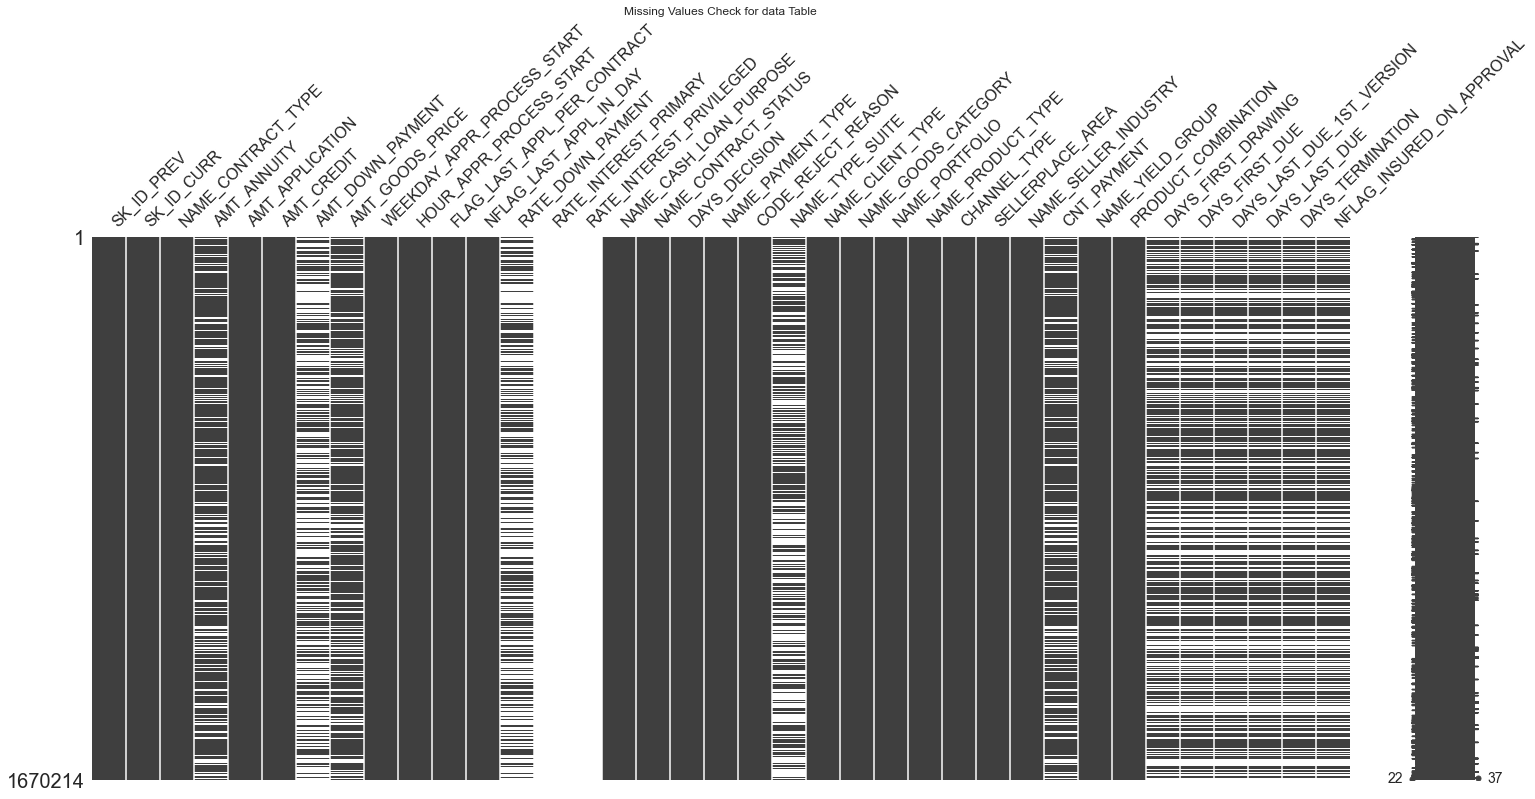

calculating for the total number of missing values in data with threshold 50.0 %....
The number of columns with over 50% missing values is: 14


,Total,Percent
RATE_INTEREST_PRIVILEGED,1664263,99.643698
RATE_INTEREST_PRIMARY,1664263,99.643698
AMT_DOWN_PAYMENT,895844,53.636480
RATE_DOWN_PAYMENT,895844,53.636480
NAME_TYPE_SUITE,820405,49.119754
NFLAG_INSURED_ON_APPROVAL,673065,40.298129
DAYS_TERMINATION,673065,40.298129
DAYS_LAST_DUE,673065,40.298129
DAYS_LAST_DUE_1ST_VERSION,673065,40.298129
DAYS_FIRST_DUE,673065,40.298129


In [83]:
missing_value_check(previous_application)

##### Missing Values Check for Bureau Table

Plotting missing values pattern for data....


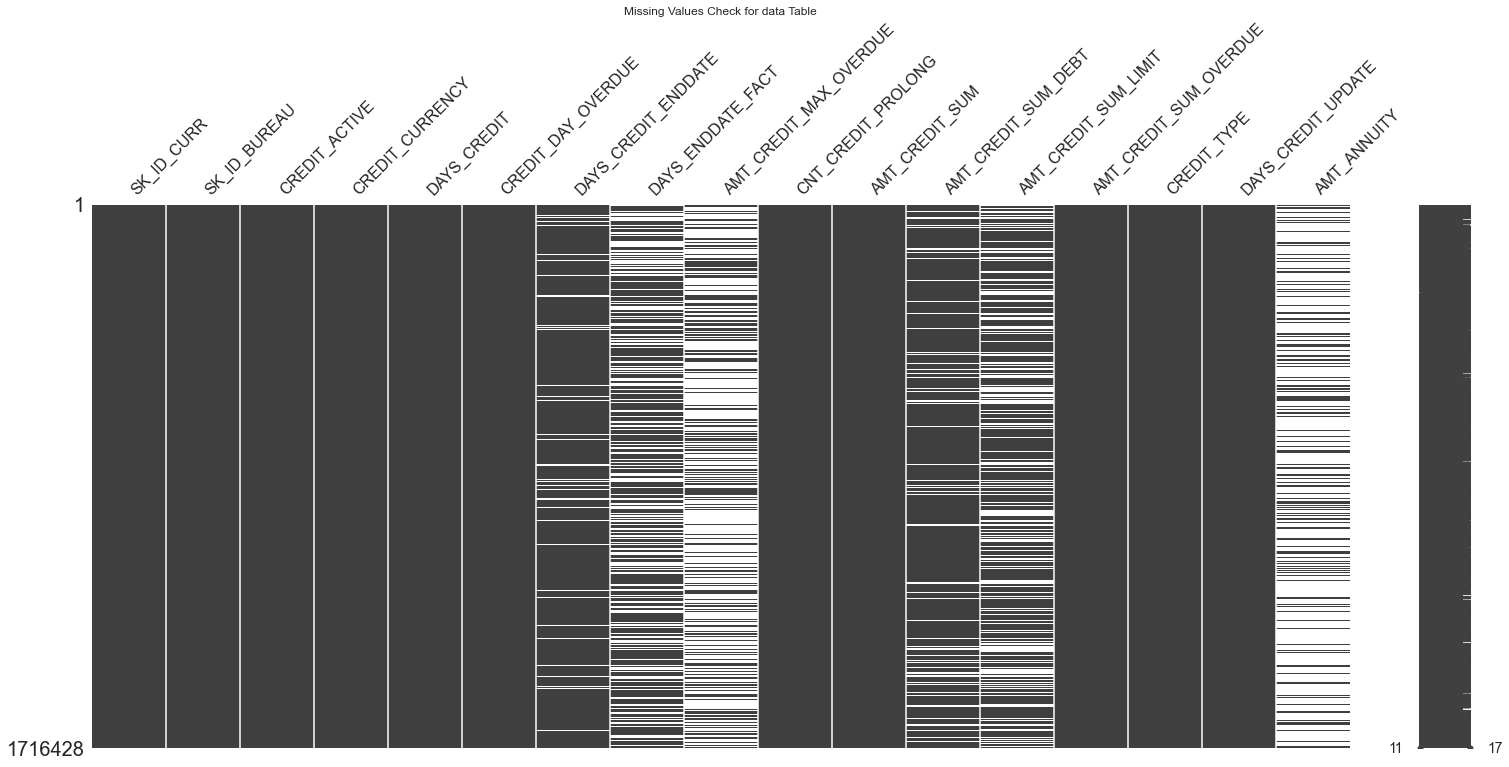

calculating for the total number of missing values in data with threshold 50.0 %....
The number of columns with over 50% missing values is: 6


,Total,Percent
AMT_ANNUITY,1226791,71.473490
AMT_CREDIT_MAX_OVERDUE,1124488,65.513264
DAYS_ENDDATE_FACT,633653,36.916958
AMT_CREDIT_SUM_LIMIT,591780,34.477415
AMT_CREDIT_SUM_DEBT,257669,15.011932
DAYS_CREDIT_ENDDATE,105553,6.149573


In [82]:
missing_value_check(bureau)

#### Missing Values Imputation

In [85]:
from sklearn.impute import SimpleImputer

In [91]:
def missing_value_imputation(data,cat_strategy = 'most_frequent',num_strategy = 'mean'):
    """
    missing_value_imputation(data,columns=None) designed for missing values imputation
    :param num_strategy:
    :param cat_strategy:
    :param data:
    :return:
    """
    total_missing_cnt = data.isnull().sum().sum()
    print('Before missing values imputation, the total number of missing values is: {}'.format(total_missing_cnt))
    cat_cols = data.select_dtypes(include=['object']).columns
    num_cols = data.select_dtypes(include=['int64','float64']).columns
    print('Creating missing values imputer for categorical columns....')
    cat_imputer = SimpleImputer(strategy= cat_strategy)
    print('Creating missing values imputer for numerical columns....')
    num_imputer = SimpleImputer(strategy= num_strategy)
    print('Fitting missing values imputer for categorical columns....')
    cat_imputer.fit(data[cat_cols])
    print('Fitting missing values imputer for numerical columns....')
    num_imputer.fit(data[num_cols])
    print('Transforming categorical columns....')
    data[cat_cols] = cat_imputer.transform(data[cat_cols])
    print('Transforming numerical columns....')
    data[num_cols] = num_imputer.transform(data[num_cols])
    total_missing_cnt = data.isnull().sum().sum()
    print('After missing values imputation, the total number of missing values is: {}'.format(total_missing_cnt))
    return data.isnull().sum().sum()

##### Missing Values Imputation for Application Table

In [92]:
missing_value_imputation(application_train,cat_strategy = 'most_frequent',num_strategy = 'mean')

Before missing values imputation, the total number of missing values is: 0
Creating missing values imputer for categorical columns....
Creating missing values imputer for numerical columns....
Fitting missing values imputer for categorical columns....
Fitting missing values imputer for numerical columns....
Transforming categorical columns....
Transforming numerical columns....
After missing values imputation, the total number of missing values is: 0


0

In [93]:
missing_value_imputation(application_test,cat_strategy = 'most_frequent',num_strategy = 'mean')

Before missing values imputation, the total number of missing values is: 1404419
Creating missing values imputer for categorical columns....
Creating missing values imputer for numerical columns....
Fitting missing values imputer for categorical columns....
Fitting missing values imputer for numerical columns....
Transforming categorical columns....
Transforming numerical columns....
After missing values imputation, the total number of missing values is: 0


0

##### Missing Values Imputation for Previous Application Table

In [94]:
missing_value_imputation(previous_application,cat_strategy = 'most_frequent',num_strategy = 'mean')

Before missing values imputation, the total number of missing values is: 11109336
Creating missing values imputer for categorical columns....
Creating missing values imputer for numerical columns....
Fitting missing values imputer for categorical columns....
Fitting missing values imputer for numerical columns....
Transforming categorical columns....
Transforming numerical columns....
After missing values imputation, the total number of missing values is: 0


0

##### Missing Values Imputation for Bureau Table

In [95]:
missing_value_imputation(bureau,cat_strategy = 'most_frequent',num_strategy = 'mean')

Before missing values imputation, the total number of missing values is: 0
Creating missing values imputer for categorical columns....
Creating missing values imputer for numerical columns....
Fitting missing values imputer for categorical columns....
Fitting missing values imputer for numerical columns....
Transforming categorical columns....
Transforming numerical columns....
After missing values imputation, the total number of missing values is: 0


0

### Duplicate Rows Check

In [116]:
def duplicate_rows_check(data):
    """
    duplicate_rows_check(data) designed for duplicate rows check
    :param data:
    :return:
    """
    print('Checking for duplicate rows in {}....'.format('data'))
    duplicate_rows_check = data.duplicated().sum()
    print('The number of duplicate rows is: {}'.format(duplicate_rows_check))

#### Duplicate Rows Check for Application Table

In [117]:
duplicate_rows_check(application_train)

Checking for duplicate rows in data....
The number of duplicate rows is: 0


In [118]:
duplicate_rows_check(application_test)

Checking for duplicate rows in data....
The number of duplicate rows is: 0


#### Duplicate Rows Check for Previous Application Table

In [119]:
duplicate_rows_check(previous_application)

Checking for duplicate rows in data....
The number of duplicate rows is: 0


#### Duplicate Rows Check for Bureau Table

In [120]:
duplicate_rows_check(bureau)

Checking for duplicate rows in data....
The number of duplicate rows is: 0


## Data Visualizations

### 1. Application Data

Application train

Application test

Overview Application dataset

In [96]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


##### 1.1 Distribution of Target Variable

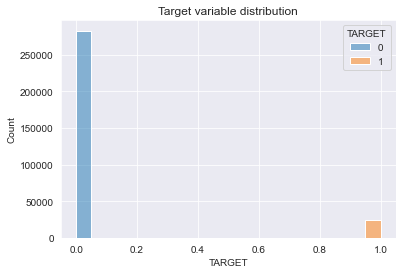

In [97]:
sns.histplot(x='TARGET',hue='TARGET',data=application_train,kde=False)
plt.title('Target variable distribution')
plt.show()

In [98]:
application_train_corr = application_train.corr().abs()
application_train_corr['TARGET'].sort_values(ascending=False).head(6)

TARGET                         1.000000
EXT_SOURCE_3                   0.178919
EXT_SOURCE_2                   0.160472
EXT_SOURCE_1                   0.155317
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
Name: TARGET, dtype: float64

In [99]:
application_train.select_dtypes(include='object').columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [100]:
application_train.var().sort_values(ascending = False).head(10)

/var/folders/xy/406yv2ts4sqg09841vwh_phm0000gn/T/ipykernel_44466/2433356958.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  application_train.var().sort_values(ascending = False).head(10)


AMT_CREDIT                1.619988e+11
AMT_GOODS_PRICE           1.364907e+11
AMT_INCOME_TOTAL          5.622739e+10
DAYS_EMPLOYED             1.995884e+10
SK_ID_CURR                1.056582e+10
AMT_ANNUITY               2.100684e+08
DAYS_BIRTH                1.904440e+07
DAYS_REGISTRATION         1.241073e+07
DAYS_ID_PUBLISH           2.278441e+06
DAYS_LAST_PHONE_CHANGE    6.836123e+05
dtype: float64

##### 1.2 External Source

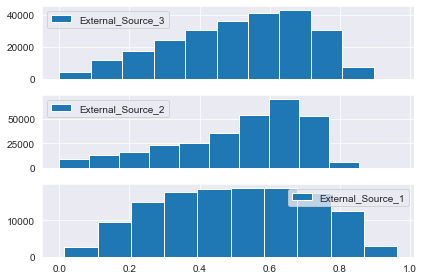

In [102]:
f,(ax1,ax2,ax3) = plt.subplots(3,1,sharex=True)
ax1.hist(application_train['EXT_SOURCE_3'],label='External_Source_3')
ax1.legend()
ax2.hist(application_train['EXT_SOURCE_2'],label='External_Source_2')
ax2.legend()
ax3.hist(application_train['EXT_SOURCE_1'],label='External_Source_1')
ax3.legend()
plt.tight_layout()
plt.show()

##### 1.3 DAYS_BIRTH

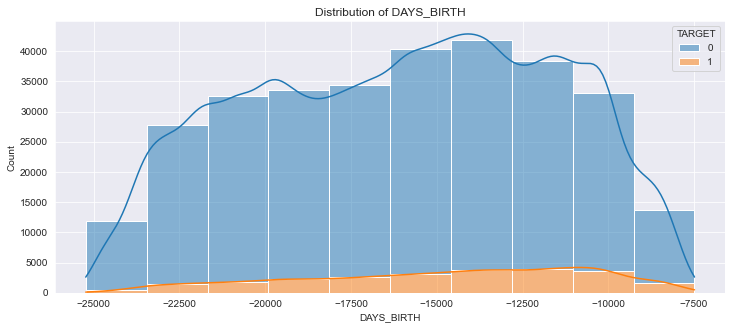

In [103]:
plt.figure(figsize=(12,5))
sns.histplot(x = 'DAYS_BIRTH',bins = 10,kde=True,
             hue='TARGET',data=application_train,multiple='stack')
plt.title("Distribution of DAYS_BIRTH")
plt.show()

##### 1.4 REGION_RATING_CLIENT_W_CITY

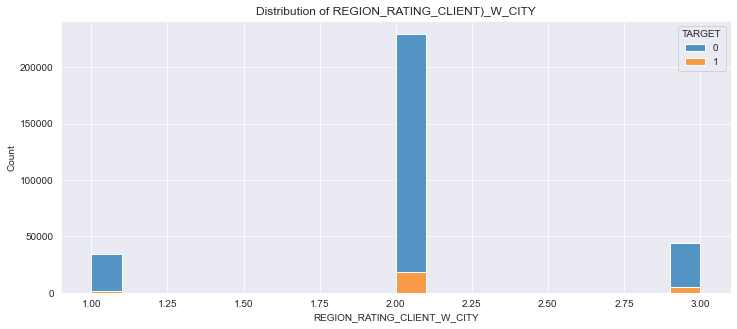

In [104]:
plt.figure(figsize=(12,5))
sns.histplot(x='REGION_RATING_CLIENT_W_CITY',hue='TARGET',data=application_train,multiple='stack')
plt.title("Distribution of REGION_RATING_CLIENT)_W_CITY")
plt.show()

##### 1.5 NAME_INCOME_TYPE

<Figure size 864x360 with 0 Axes>

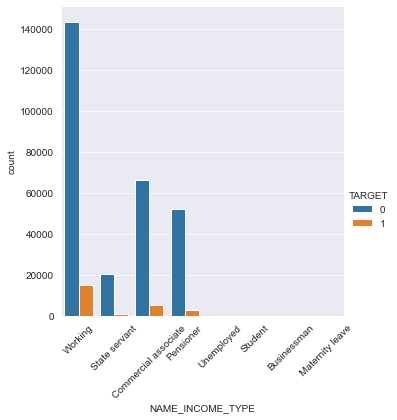

In [105]:
plt.figure(figsize=(12,5))
sns.catplot(data=application_train,x='NAME_INCOME_TYPE',kind='count',hue='TARGET')
plt.xticks(rotation=45)
plt.show()

<Figure size 864x360 with 0 Axes>

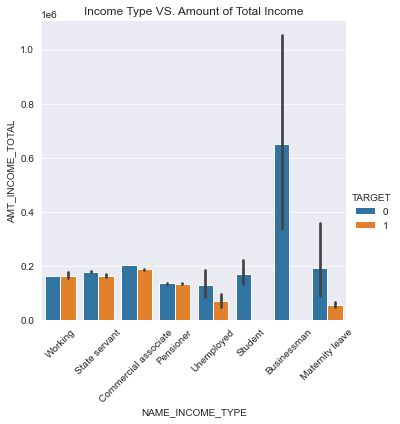

In [106]:
plt.figure(figsize=(12,5))
sns.catplot(data=application_train,x='NAME_INCOME_TYPE',y='AMT_INCOME_TOTAL'
            ,hue='TARGET',kind='bar')
plt.xticks(rotation=45)
plt.title('Income Type VS. Amount of Total Income')
plt.show()

##### 1.6 NAME_EDUCATION_TYPE

<Figure size 864x360 with 0 Axes>

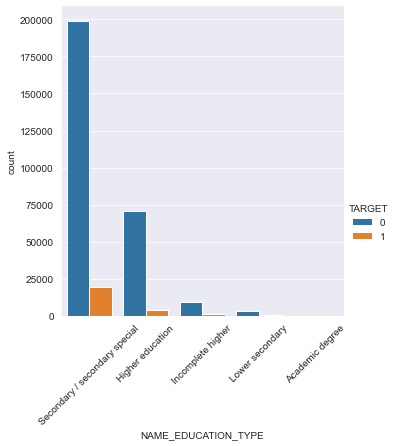

In [107]:
plt.figure(figsize=(12,5))
sns.catplot(data=application_train,x='NAME_EDUCATION_TYPE',kind='count',hue='TARGET')
plt.xticks(rotation=45)
plt.show()

<Figure size 864x360 with 0 Axes>

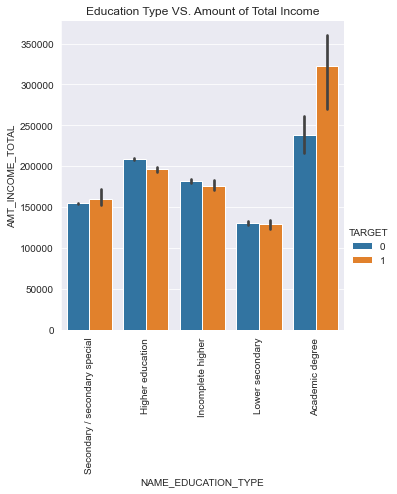

In [108]:
plt.figure(figsize=(12,5))
sns.catplot(data=application_train,x='NAME_EDUCATION_TYPE',y='AMT_INCOME_TOTAL'
            ,hue='TARGET',kind='bar',estimator=np.mean)
plt.xticks(rotation=90)
plt.title('Education Type VS. Amount of Total Income')
plt.show()

##### 1.7 NAME_FAMILY_STATUS

<Figure size 864x360 with 0 Axes>

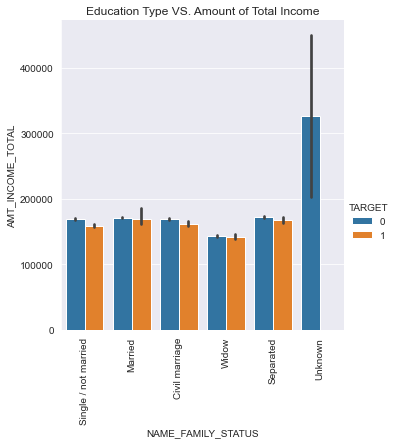

In [109]:
plt.figure(figsize=(12,5))
sns.catplot(data=application_train,x='NAME_FAMILY_STATUS',y='AMT_INCOME_TOTAL'
            ,hue='TARGET',kind='bar',estimator=np.mean)
plt.xticks(rotation=90)
plt.title('Education Type VS. Amount of Total Income')
plt.show()

##### 1.8 OCCUPATION_TYPE

<Figure size 1440x720 with 0 Axes>

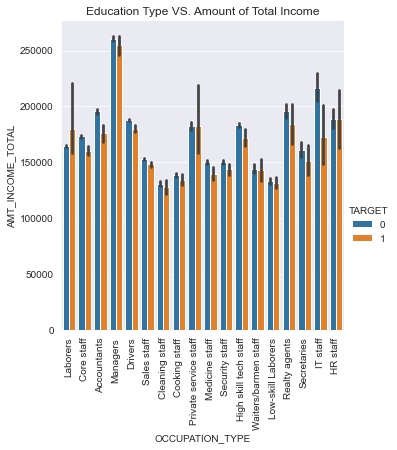

In [110]:
plt.figure(figsize=(20,10))
sns.catplot(data=application_train,x='OCCUPATION_TYPE',y='AMT_INCOME_TOTAL'
            ,hue='TARGET',kind='bar',estimator=np.mean)
plt.xticks(rotation=90)
plt.title('Education Type VS. Amount of Total Income')
plt.show()

##### 1.9 ORGANIZATION_TYPE

<Figure size 2160x1440 with 0 Axes>

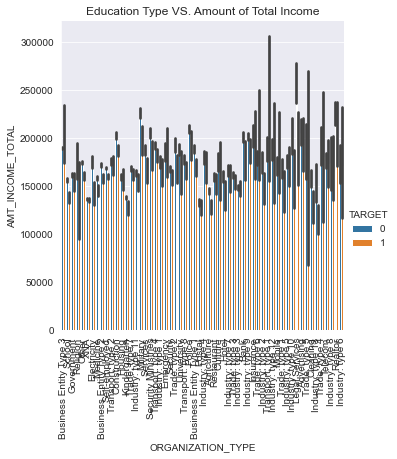

In [111]:
plt.figure(figsize=(30,20))
sns.catplot(data=application_train,x='ORGANIZATION_TYPE',y='AMT_INCOME_TOTAL'
            ,hue='TARGET',kind='bar',estimator=np.mean)
plt.xticks(rotation=90)
plt.title('Education Type VS. Amount of Total Income')
plt.show()

##### 1.10 WEEKDAY_APPR_PROCESS_START

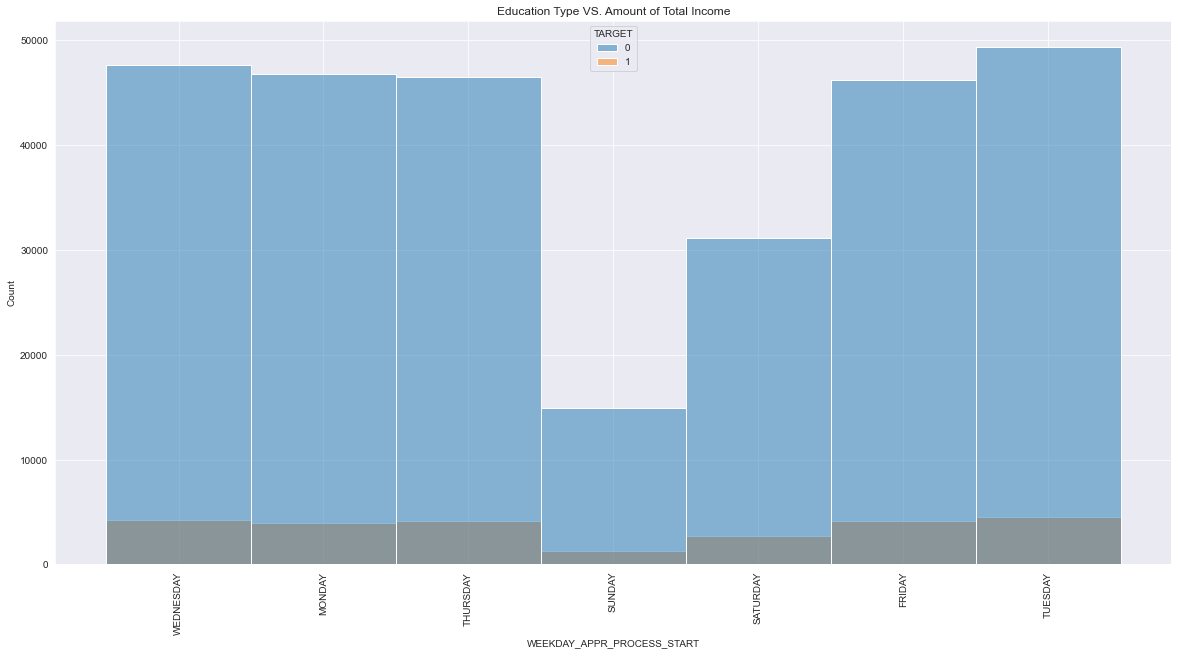

In [112]:
plt.figure(figsize=(20,10))
sns.histplot(data=application_train,x='WEEKDAY_APPR_PROCESS_START'
            ,hue='TARGET')
plt.xticks(rotation=90)
plt.title('Education Type VS. Amount of Total Income')
plt.show()

### 2. Bureau Data

Bureau data contains all client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in the sample). For every loan in the sample, there are as many rows as number of credits the client had in Credit Bureau before the application date. SK_ID_CURR is the key connecting application_train|test data with bureau data.

Let's merge application_train with bureau.

In [121]:
bureau_application = bureau.merge(application_train, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

In [123]:
bureau_application_corr = bureau_application.corr().abs()

bureau_application_corr_col = list(bureau.columns)
bureau_application_corr_col.append('TARGET')

bureau_application_corr[bureau_application_corr.columns.
                        isin(bureau_application_corr_col)]['TARGET'].sort_values(ascending = False)

TARGET                    1.000000
DAYS_CREDIT               0.061556
DAYS_CREDIT_UPDATE        0.041076
DAYS_ENDDATE_FACT         0.029503
DAYS_CREDIT_ENDDATE       0.025442
AMT_CREDIT_SUM            0.010606
SK_ID_BUREAU              0.009018
AMT_CREDIT_SUM_OVERDUE    0.006253
AMT_CREDIT_SUM_LIMIT      0.004886
SK_ID_CURR                0.003024
CREDIT_DAY_OVERDUE        0.002652
AMT_CREDIT_SUM_DEBT       0.002343
CNT_CREDIT_PROLONG        0.001523
AMT_CREDIT_MAX_OVERDUE    0.000954
Name: TARGET, dtype: float64

TARGET                    1.000000
DAYS_CREDIT               0.061556
DAYS_CREDIT_UPDATE        0.041076
DAYS_ENDDATE_FACT         0.029503
DAYS_CREDIT_ENDDATE       0.025442
AMT_CREDIT_SUM            0.010606
SK_ID_BUREAU              0.009018
AMT_CREDIT_SUM_OVERDUE    0.006253
AMT_CREDIT_SUM_LIMIT      0.004886
SK_ID_CURR                0.003024
CREDIT_DAY_OVERDUE        0.002652
AMT_CREDIT_SUM_DEBT       0.002343
CNT_CREDIT_PROLONG        0.001523
AMT_CREDIT_MAX_OVERDUE    0.000954
Name: TARGET, dtype: float64

In [124]:
bureau.select_dtypes(include='object').columns

Index(['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE'], dtype='object')

In [125]:
bureau['CREDIT_ACTIVE'].unique()

array(['Closed', 'Active', 'Sold', 'Bad debt'], dtype=object)

##### 2.1 CREDIT_TYPE

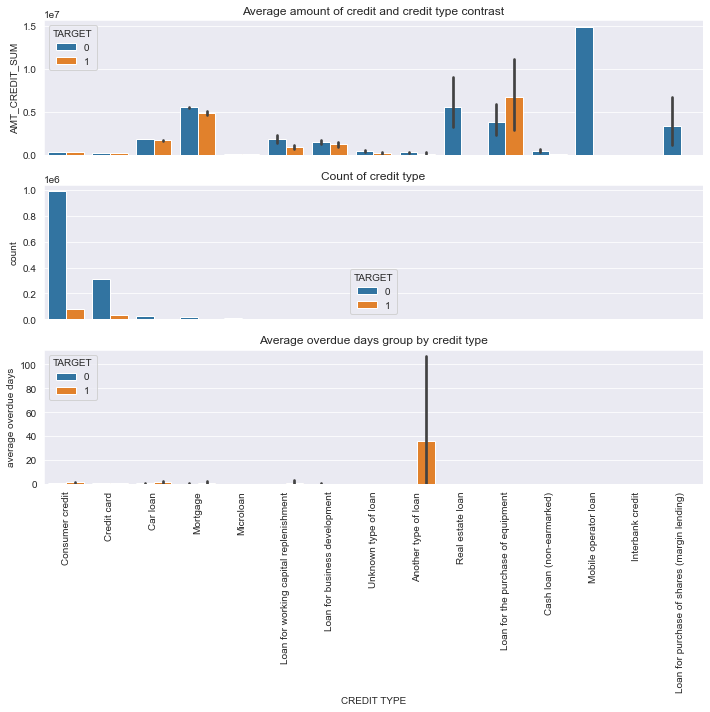

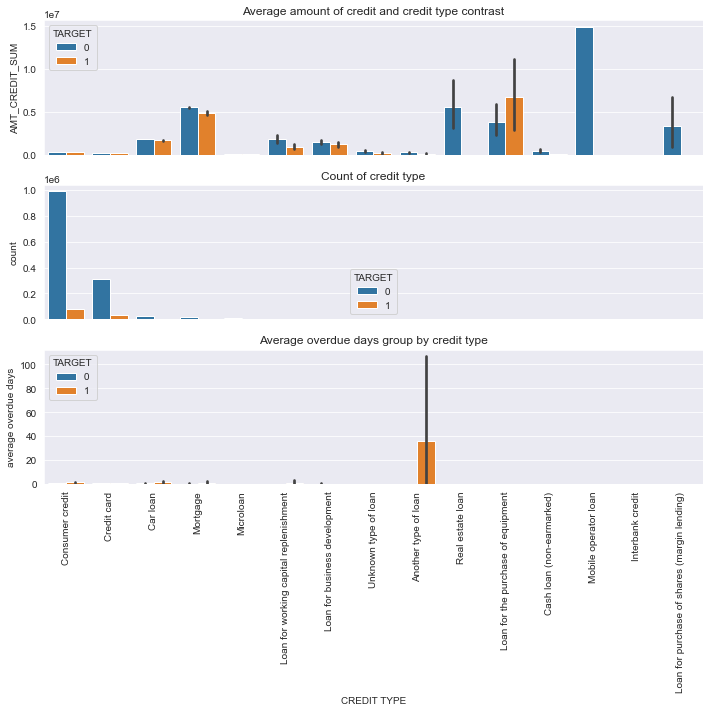

In [129]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows=3,ncols=1,sharex=True,figsize= (10,10))
plt.subplot(3,1,1)
sns.barplot(data = bureau_application,x = 'CREDIT_TYPE',y='AMT_CREDIT_SUM',estimator=np.mean,ax = ax1,hue='TARGET')
plt.xticks(rotation = 90)
ax1.xaxis.set_visible(False)
plt.title('Average amount of credit and credit type contrast')
plt.subplot(3,1,2)
sns.countplot(data= bureau_application, x='CREDIT_TYPE',ax = ax2,hue='TARGET')
plt.xticks(rotation = 90)
plt.title('Count of credit type')
ax2.xaxis.set_visible(False)
plt.subplot(3,1,3)
sns.barplot(data= bureau_application, x = 'CREDIT_TYPE', y = 'CREDIT_DAY_OVERDUE', estimator=np.mean,ax = ax3,hue='TARGET')
plt.xticks(rotation = 90)
plt.xlabel('CREDIT TYPE')
plt.title('Average overdue days group by credit type')
plt.ylabel('average overdue days')
plt.tight_layout()
plt.show()

##### 2.2 CREDIT_CURRENCY

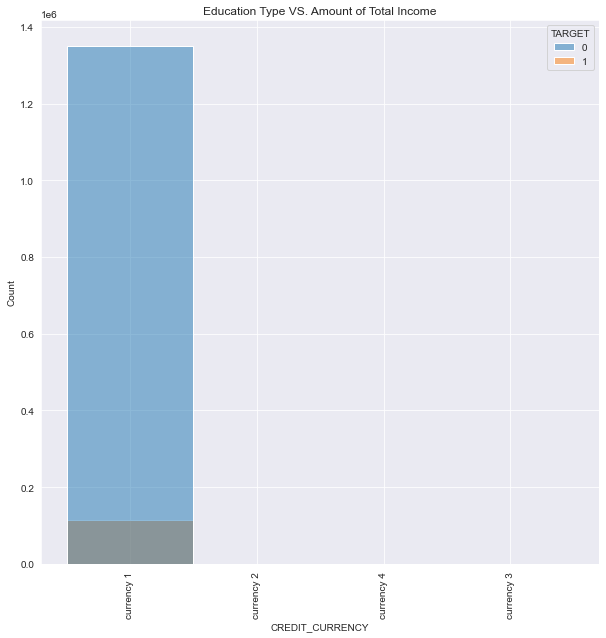

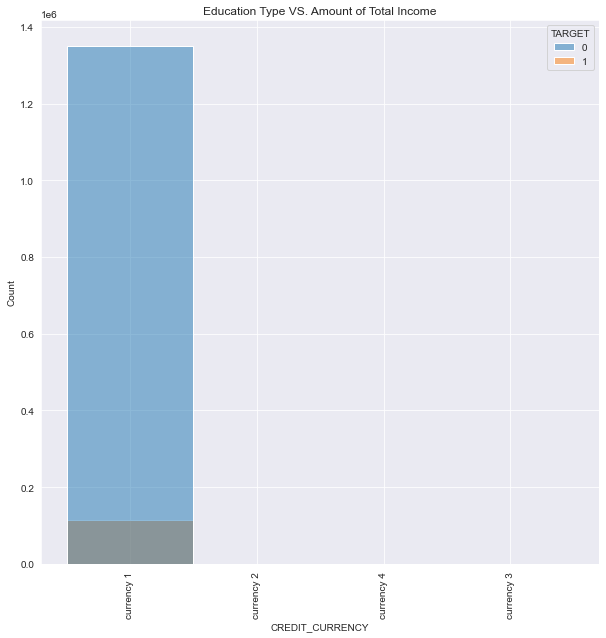

In [130]:
plt.figure(figsize=(10,10))
sns.histplot(data=bureau_application,x='CREDIT_CURRENCY'
            ,hue='TARGET')
plt.xticks(rotation=90)
plt.title('Education Type VS. Amount of Total Income')
plt.show()

In [131]:
currency_default_cnt = pd.DataFrame(bureau_application.groupby(['CREDIT_CURRENCY'])['TARGET'].value_counts())
currency_default_cnt['PERCENT'] = bureau_application.groupby(['CREDIT_CURRENCY'])['TARGET']\
.value_counts(normalize=True).values
currency_default_cnt

TARGET   PERCENT
CREDIT_CURRENCY TARGET                   
currency 1      0       1349640  0.921826
                1        114454  0.078174
currency 2      0          1023  0.954291
                1            49  0.045709
currency 3      0           133  0.886667
                1            17  0.113333
currency 4      0             9  1.000000

TARGET   PERCENT
CREDIT_CURRENCY TARGET                   
currency 1      0       1349640  0.921826
                1        114454  0.078174
currency 2      0          1023  0.954291
                1            49  0.045709
currency 3      0           133  0.886667
                1            17  0.113333
currency 4      0             9  1.000000

### 3.Previous Application Data

The dataframe previous_application contains information about all previous applications for Home Credit loans of clients who have loans in the sample. There is one row for each previous application related to loans in our data sample. SK_ID_CURR is the key connecting application_train|test data with previous_application data.

Let's merge application_train with previous_application.

In [132]:
previous_application_application = previous_application.merge(application_train, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

In [133]:
previous_application_application_corr = previous_application_application.corr().abs()

previous_application_application_corr_col = list(previous_application.columns)
previous_application_application_corr_col.append('TARGET')



In [134]:
previous_application_application_corr[previous_application_application_corr.columns.
                        isin(previous_application_application_corr_col)]['TARGET'].\
sort_values(ascending=False).head(5)

TARGET                1.000000
DAYS_DECISION         0.039901
CNT_PAYMENT           0.026536
DAYS_FIRST_DRAWING    0.022802
RATE_DOWN_PAYMENT     0.017041
Name: TARGET, dtype: float64

In [135]:
previous_application.select_dtypes(include='object').columns

Index(['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON',
       'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY',
       'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE',
       'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION'],
      dtype='object')

##### 3.1 DAYS_DECISION

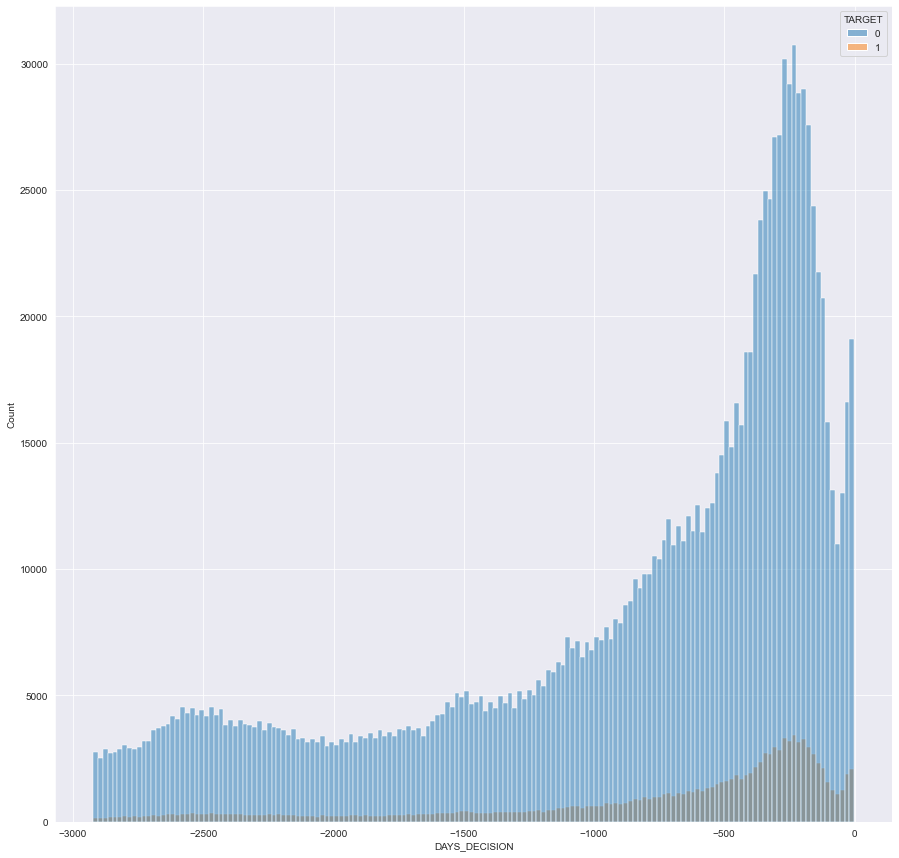

In [136]:
plt.figure(figsize=(15,15))
sns.histplot(x='DAYS_DECISION',data=previous_application_application,hue='TARGET')
plt.show()

##### 3.2 CNT_PAYMENT

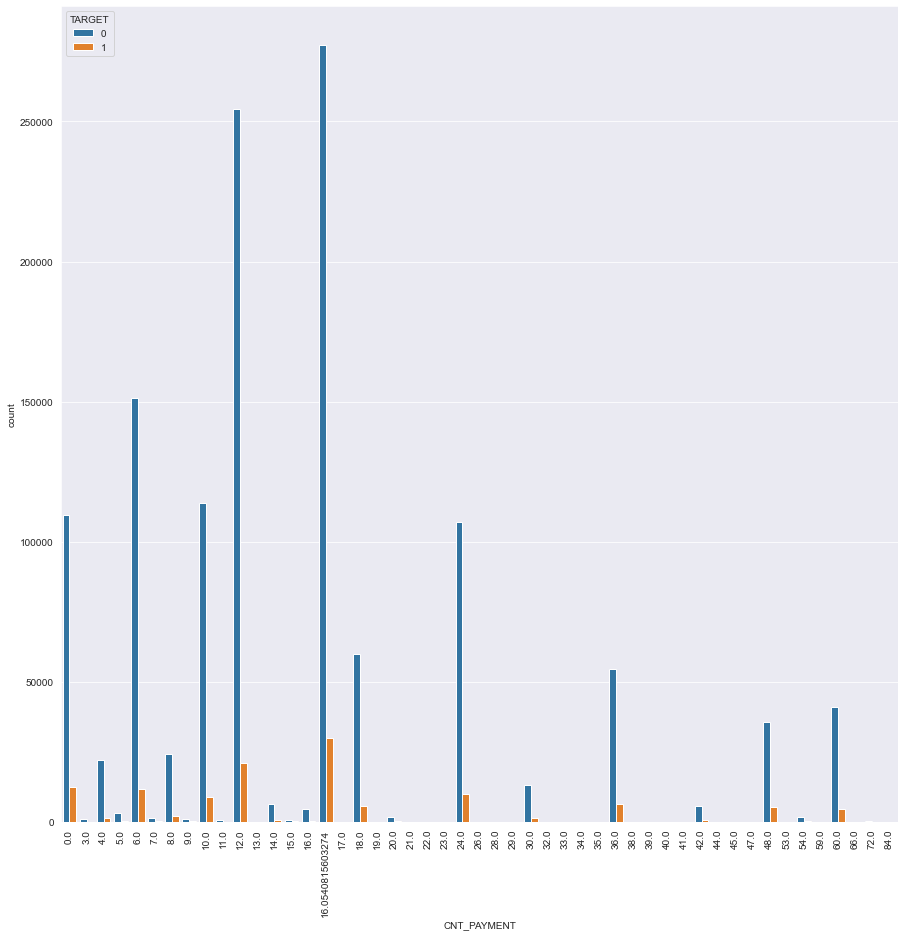

In [137]:
plt.figure(figsize=(15,15))
sns.countplot(x='CNT_PAYMENT',data=previous_application_application,hue='TARGET')
plt.xticks(rotation = 90)
plt.show()

##### 3.3 NAME_CONTRACT_TYPE

<Figure size 2160x1440 with 0 Axes>

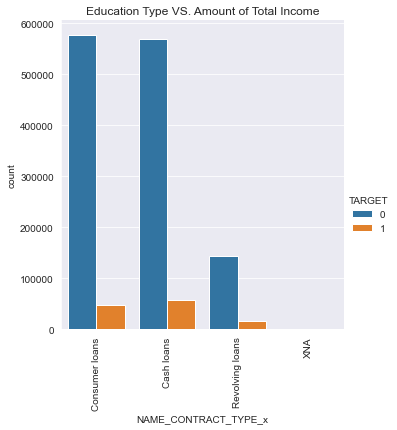

In [138]:
plt.figure(figsize=(30,20))
sns.catplot(data=previous_application_application,x='NAME_CONTRACT_TYPE_x'
            ,hue='TARGET',kind='count')
plt.xticks(rotation=90)
plt.title('Education Type VS. Amount of Total Income')
plt.show()

##### 3.4 CODE_REJECT_REASON

<Figure size 2160x1440 with 0 Axes>

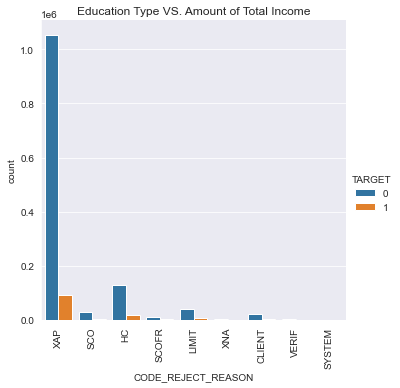

In [139]:
plt.figure(figsize=(30,20))
sns.catplot(data=previous_application_application,x='CODE_REJECT_REASON'
            ,hue='TARGET',kind='count')
plt.xticks(rotation=90)
plt.title('Education Type VS. Amount of Total Income')
plt.show()

#### 3.5 Amount customers previously requested VS. Amount customers finally got approved

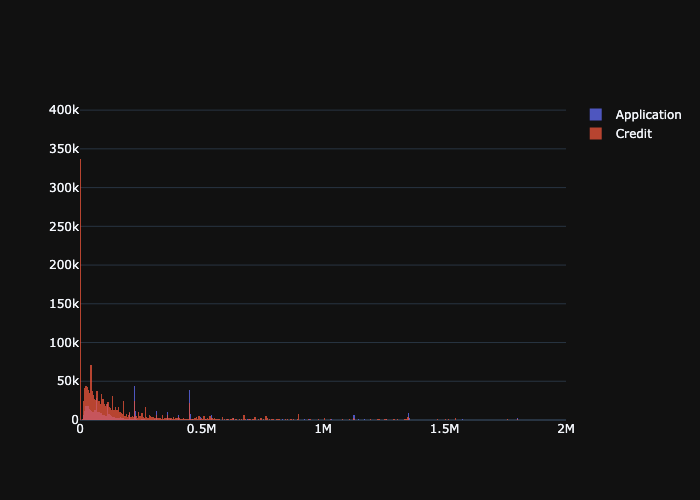

In [141]:
import plotly.graph_objects as go
x0 =previous_application['AMT_APPLICATION']
x1 =previous_application['AMT_CREDIT']
fig = go.Figure()
fig.add_trace(go.Histogram(x=x0,name='Application'))
fig.add_trace(go.Histogram(x=x1,name='Credit'))
fig.update_layout(barmode='overlay')
fig.update_traces(opacity = 0.75)
fig.update_xaxes(range=[0,2000000])
fig.show('png')

#### 3.6 Average goods price

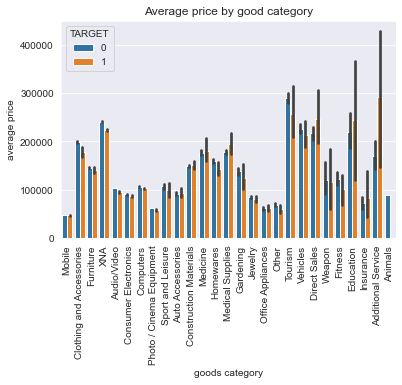

In [142]:
sns.barplot(data= previous_application_application,x='NAME_GOODS_CATEGORY',y = 'AMT_APPLICATION',hue='TARGET', estimator= np.mean)
plt.xticks(rotation = 90)
plt.xlabel('goods category')
plt.ylabel('average price')
plt.title('Average price by good category')
plt.show()

#### 3.7 NAME_CASH_LOAN_PURPOSE

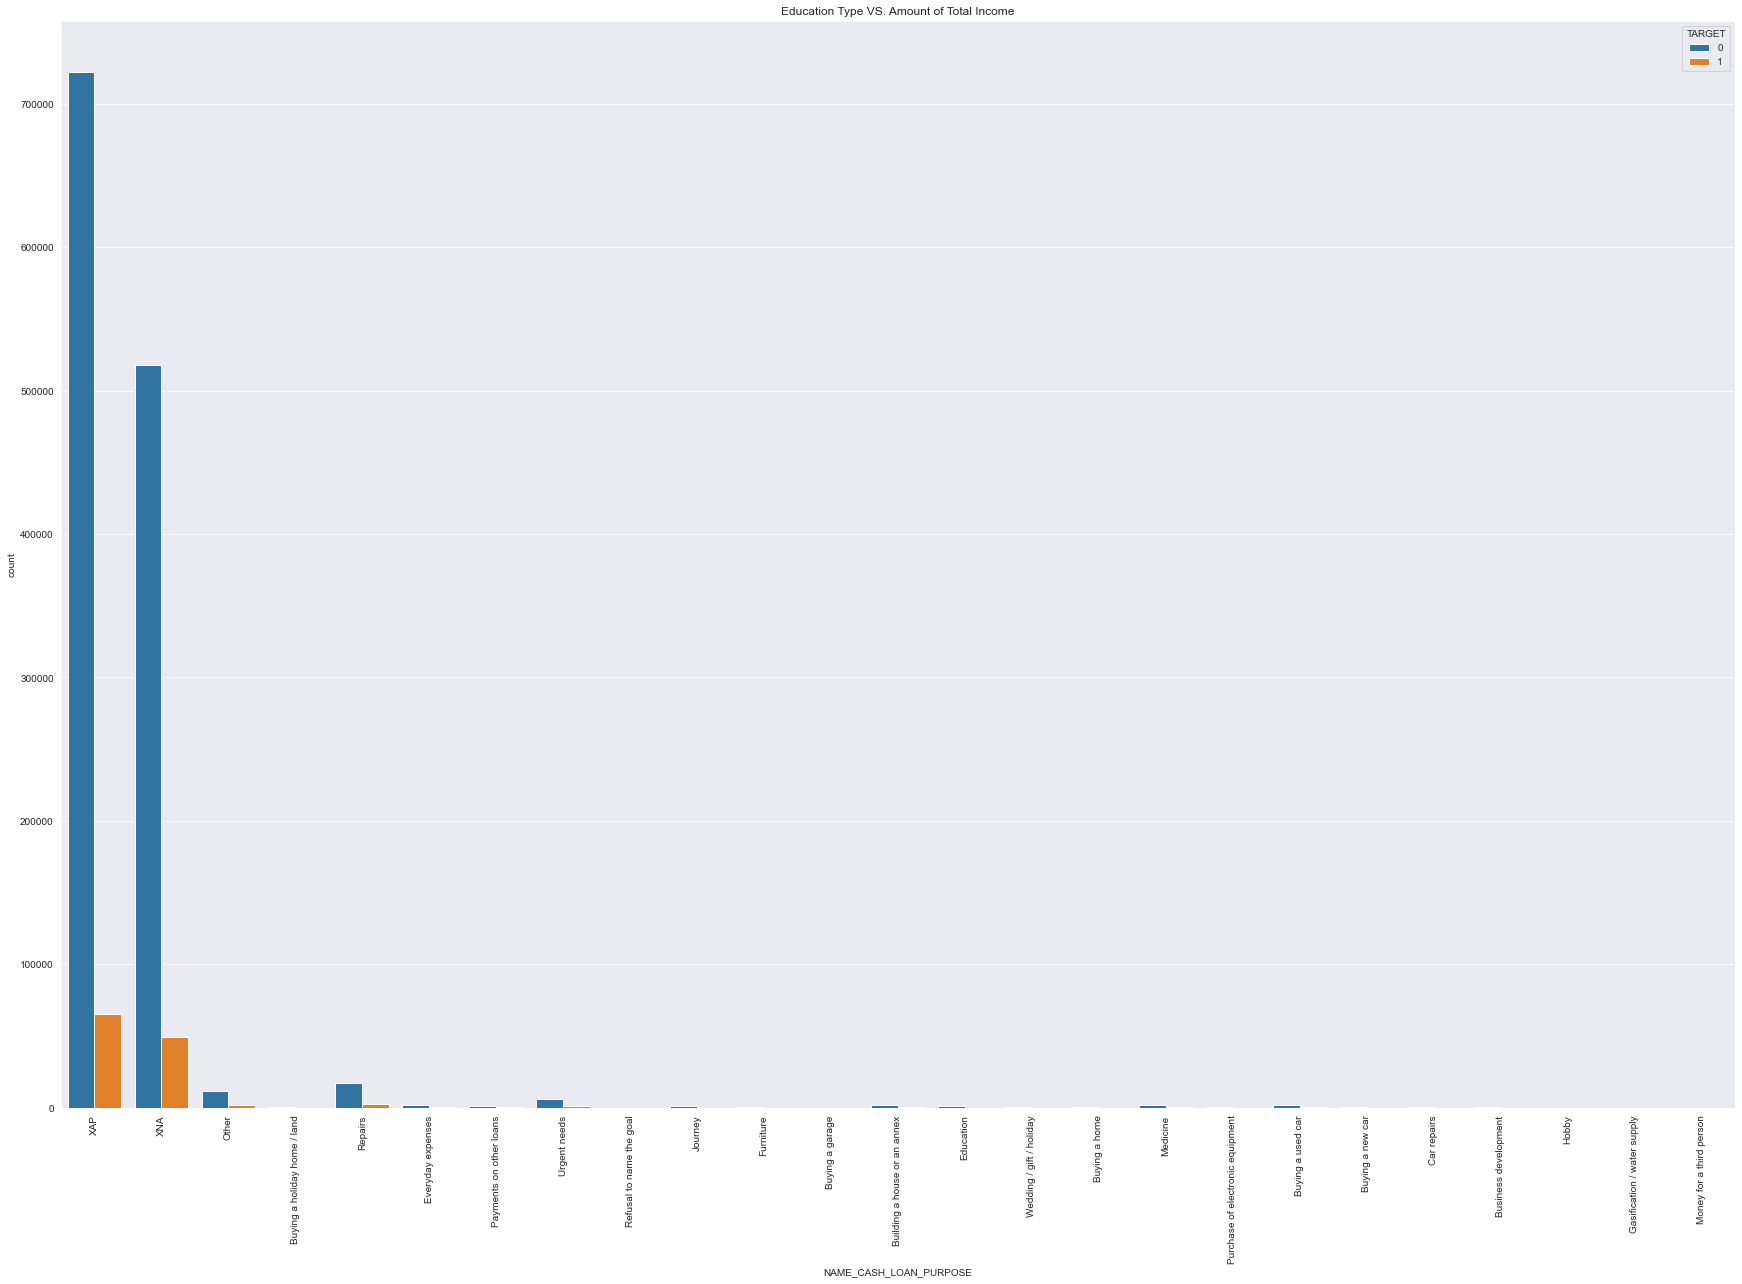

In [143]:
plt.figure(figsize=(30,20))
sns.countplot(data=previous_application_application,x='NAME_CASH_LOAN_PURPOSE'
            ,hue='TARGET')
plt.xticks(rotation=90)
plt.title('Education Type VS. Amount of Total Income')
plt.show()

# Feature Engineering

## Encoding Categorical Columns

In [144]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

### Label Encoding

In [ ]:
cat_col = train_data.select_dtypes(include='object').columns

In [ ]:
for i in cat_col:
    print(f'The column of {i} has unique values \n {train_data[i].unique()}\n\n')

In [ ]:
label_encode_col = ['WEEKDAY_APPR_PROCESS_START','NAME_EDUCATION_TYPE']

In [ ]:
mapping_weekday = {'MONDAY':1,'TUESDAY':2,'WEDNESDAY':3,'THURSDAY':4,'FRIDAY':5,'SATURDAY':0,'SUNDAY':6}
mapping_education = {'Lower secondary':0,'Secondary / secondary special':1,'Incomplete higher':2,'Higher education':3,'Academic degree':4}

In [ ]:
train_data['WEEKDAY_APPR_PROCESS_START_label'] = train_data['WEEKDAY_APPR_PROCESS_START'].map(mapping_weekday)
train_data['NAME_EDUCATION_TYPE_label'] = train_data['NAME_EDUCATION_TYPE'].map(mapping_education)


In [ ]:
test_data['WEEKDAY_APPR_PROCESS_START_label'] = test_data['WEEKDAY_APPR_PROCESS_START'].map(mapping_weekday)
test_data['NAME_EDUCATION_TYPE_label'] = test_data['NAME_EDUCATION_TYPE'].map(mapping_education)

In [ ]:
onehot_encode_ = list(cat_col.difference(label_encode_col))
onehot_encode_

### One-hot Encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder
# Instantiate the OneHotEncoder
ohe = OneHotEncoder()

In [ ]:
for col in onehot_encode_:
    subcategory = pd.DataFrame(train_data[col])
    encoded = ohe.fit_transform(subcategory)
    dense_array = encoded.toarray()
    # Put into a dataframe to get column names
    encoded_df = pd.DataFrame(dense_array, columns=ohe.categories_, dtype=int)
    train_data = pd.concat((train_data,encoded_df),axis='columns')

In [ ]:
for col in onehot_encode_:
    subcategory = pd.DataFrame(test_data[col])
    encoded = ohe.fit_transform(subcategory)
    dense_array = encoded.toarray()
    # Put into a dataframe to get column names
    encoded_df = pd.DataFrame(dense_array, columns=ohe.categories_, dtype=int)
    test_data = pd.concat((test_data,encoded_df),axis='columns')

In [ ]:
clean_train_df = train_data.drop(columns =cat_col)

clean_test_df = test_data.drop(columns = cat_col)



In [ ]:
clean_test_df.shape == clean_train_df.shape

In [ ]:
def Diff(li1, li2):
    return list(set(li1) - set(li2)) + list(set(li2) - set(li1))

In [ ]:
Diff(clean_test_df,clean_train_df)

In [ ]:
clean_test_df.shape[0]

In [ ]:
d = {('Maternity leave',):[0]*(clean_test_df.shape[0]),('Unknown',):[0]*clean_test_df.shape[0]}
df = pd.DataFrame(data=d)
clean_test_df = pd.concat((clean_test_df,df),axis='columns')


In [ ]:
Diff(clean_test_df,clean_train_df)

# Modeling

## Feature Selection

### Remove Multicolinearity

In [ ]:
# Threshold for removing correlated variables
threshold = 0.8

# Absolute value correlation matrix
corr_matrix = clean_train_df.corr().abs()
corr_matrix.head()

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix)
plt.title('Correlation Heatmap among variables')
plt.show()

In [ ]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

In [ ]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

In [ ]:
clean_train_df = clean_train_df.drop(columns = to_drop,axis='columns')
clean_test_df = clean_test_df.drop(columns = to_drop,axis='columns')

print('Training shape: ', clean_train_df.shape)
print('Testing shape: ', clean_test_df.shape)

## Base Model

In [ ]:
## Scaling
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
X_train = clean_train_df.drop('TARGET',axis='columns')
y_train = clean_train_df['TARGET']
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled =  min_max_scaler.fit_transform(clean_test_df)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [ ]:
logreg = LogisticRegression(solver = 'liblinear')
params = {'C':[0.01,0.1,1,10,100]}
grid_search = GridSearchCV(estimator=logreg,param_grid=params,n_jobs=-1,cv=10)
grid_search.fit(X_train_scaled,y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
logreg = LogisticRegression(C=0.1,solver= 'liblinear')
logreg.fit(X_train_scaled,y_train)
prediction = logreg.predict(X_test_scaled)

## Ensemble Model

In [ ]:
prediction.shape

In [ ]:
submit = pd.read_csv('/Users/yuegao/ML_Projects/capstone/workplace/sample_submission.csv')
submit.head()

In [ ]:
submit['TARGET'] = prediction
submit.head()

In [ ]:
submit.to_csv('log_reg_baseline.csv', index = False)

In [ ]:
sns.barplot(data= previous_application_application,x='NAME_GOODS_CATEGORY',y = 'AMT_APPLICATION',hue='TARGET', estimator= np.mean)
plt.xticks(rotation = 90)
plt.xlabel('goods category')
plt.ylabel('average price')
plt.title('Average price by good category')
plt.show()

NAME_CASH_LOAN_PURPOSE

In [ ]:
plt.figure(figsize=(30,20))
sns.countplot(data=previous_application_application,x='NAME_CASH_LOAN_PURPOSE'
            ,hue='TARGET')
plt.xticks(rotation=90)
plt.title('Education Type VS. Amount of Total Income')
plt.show()